# Various tests for pipeline checks

In [1]:
!pip3 install --upgrade --user hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.5 MB/s eta 0:00:00


In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Import variables


In [1]:
import sys
import os
import io
import logging

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import bigquery
from dask import delayed
import pandas as pd
from sklearn.utils import check_random_state
from scipy.stats import entropy


# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Python packages for data, stats
import numpy as np
import ast
import pandas as pd
import seaborn as sns
import random

# ML
import sklearn
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# HMM
#from hmmlearn.vhmm import VariationalGaussianHMM

# To get the time
from datetime import datetime

# To write on the same line
from IPython.display import clear_output

# Set a random seed for reproducibility
random_seed = 42

# Setting the random seed for various libraries
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import seaborn as sns




In [2]:
bq_client = bigquery.Client()
storage_client = storage.Client()

In [3]:
PROJECT_ID = "hmh-em-deepasm"
SAMPLES_DATASET = "samples_250bp"
ML_DATASET = "ml_250bp_2"
BUCKET = "hmh_deepasm"

# Make sure this is the same as in the config file
dic_data = {'TRAINING': {'samples': ['gm12878',
                                  'CD14',
                                  'fibroblast',
                                  'A549',
                                  'spleen_female_adult',
                                  'HeLa_S3']},
            'VALIDATION': {'samples': ['mammary_epithelial',
                                       'sk_n_sh',
                                       'CD34']},
            'TESTING': {'samples': ['HepG2',
                                 'righ_lobe_liver',
                                 't_cell_male_adult']}}

## Functions used in the notebook

In [4]:
# def plot_balanced_overlayed_distributions(df, column_names, separator_column='asm'):
#     """
#     Plots the distribution of specified columns in a DataFrame, overlaying balanced distributions
#     based on the separator column values (0 and 1), with distinct colors for each category and only one legend.

#     Args:
#     df (pandas.DataFrame): The DataFrame containing the data.
#     column_names (list of str): The names of the columns to plot.
#     separator_column (str): The name of the column used to separate the DataFrame into two groups.

#     Returns:
#     fig (plotly.graph_objects.Figure): A Plotly Figure object containing the overlayed distribution plots with a single legend.
#     """

#     opacity_hist = 0.3

#     # Separate the DataFrame based on the separator column values
#     df_0 = df[df[separator_column] == 0]
#     df_1 = df[df[separator_column] == 1]

#     # Balance the dataset by sampling
#     min_count = min(len(df_0), len(df_1))
#     df_0_sampled = df_0.sample(n=min_count, random_state=1)
#     df_1_sampled = df_1.sample(n=min_count, random_state=1)

#     # Number of columns to plot
#     num_columns = len(column_names)

#     # Creating subplots: one row for each specified column
#     fig = make_subplots(rows=num_columns, cols=1)

#     # Adding overlayed histogram subplots for each specified column
#     for i, column in enumerate(column_names, start=1):
#         fig.add_trace(go.Histogram(x=df_0_sampled[column],
#                                    name=f"{separator_column} = 0",
#                                    marker_color='blue',
#                                    opacity=opacity_hist,
#                                    showlegend=(i==1)),
#                       row=i, col=1)
#         fig.add_trace(go.Histogram(x=df_1_sampled[column],
#                                    name=f"{separator_column} = 1",
#                                    marker_color='red',
#                                    opacity=opacity_hist,
#                                    showlegend=(i==1)),
#                       row=i, col=1)

#         # Update x-axis title
#         fig.update_xaxes(title_text=column, row=i, col=1)

#     # Update layout for better readability, display, and single legend configuration
#     fig.update_layout(height=300*num_columns, title_text="Balanced Overlayed Column Distributions", barmode='overlay', showlegend=True)

#     return fig

def plot_balanced_overlayed_distributions(df, column_names, separator_column='asm'):
    """
    Plots the distribution of specified columns in a DataFrame, overlaying balanced distributions
    based on the separator_column values (0 and 1), with distinct colors for each category and only one legend.

    Args:
    df (pandas.DataFrame): The DataFrame containing the data.
    column_names (list of str): The names of the columns to plot.
    separator_column (str): The name of the column used to separate the DataFrame into two groups.
    """
    # Define colors for the histograms
    colors = {'0': 'blue', '1': 'red'}
    alpha = 0.3  # Opacity of histograms

    # Separate the DataFrame based on the separator column values
    df_0 = df[df[separator_column] == 0]
    df_1 = df[df[separator_column] == 1]

    # Balance the dataset by sampling
    min_count = min(len(df_0), len(df_1))
    df_0_sampled = df_0.sample(n=min_count, random_state=1)
    df_1_sampled = df_1.sample(n=min_count, random_state=1)

    # Creating a figure with subplots
    fig, axes = plt.subplots(nrows=len(column_names), ncols=1, figsize=(10, 5 * len(column_names)))

    # Making sure axes is iterable when there's only one subplot
    if len(column_names) == 1:
        axes = [axes]

    # Adding overlayed histogram subplots for each specified column
    for ax, column in zip(axes, column_names):
        ax.hist(df_0_sampled[column], bins=30, color='blue', alpha=alpha, label=f"{separator_column} = 0")
        ax.hist(df_1_sampled[column], bins=30, color='red', alpha=alpha, label=f"{separator_column} = 1")

        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        # Only add legend to the first subplot
        if ax is axes[0]:
            ax.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# def plot_cpg_regions_from_df(df, array_col, var_col, N, var_values=(0, 1)):
#     """
#     Plots 2D arrays from a specified column in a DataFrame, separated into two groups
#     based on another variable. Rows are sampled randomly. The plots have customized x-labels
#     and y-labels, and the colors are mapped to specific meanings.

#     Parameters:
#     - df: DataFrame containing the data.
#     - array_col: The name of the column with the 2D arrays.
#     - var_col: The name of the column to use for separating the data into two groups.
#     - N: Number of arrays to plot for each group.
#     - var_values: A tuple with the two values of the variable to use for grouping the arrays.
#     """
#     rows = N  # Assuming 1 plot per array

#     # Custom colorscale for the meanings of 0, 1, and 2
#     colorscale = [[0, 'lightgrey'], [1/3, 'lightgrey'],  # no CpG
#                   [1/3, 'SkyBlue'], [2/3, 'SkyBlue'],  # Unmethylated CpG
#                   [2/3, 'Purple'], [1, 'Purple']]  # Methylated CpG


#     subplot_titles = []
#     for i in range(N):
#         for v in var_values:
#             subplot_titles.append(f'ASM: {v}')

#     # Create subplots with N rows and 2 columns
#     fig = make_subplots(rows=rows, cols=2,
#                         subplot_titles=subplot_titles,
#                         horizontal_spacing=0.10, vertical_spacing=0.07)

#     # Function to add traces for each group
#     def add_traces(group, col, asm_value):
#         for i, arr in enumerate(group.sample(n=N, random_state=42), start=1):
#             #arr = np.array(ast.literal_eval(arr_str))
#             # Add heatmap
#             transposed_matrix = list(map(list, zip(*arr)))
#             fig.add_trace(
#                 go.Heatmap(z=transposed_matrix, colorscale=colorscale, showscale=False),
#                 row=i, col=col
#             )
#             # Set x-axis title
#             #fig.update_layout(title_text= f'ASM: {asm_value}')
#             fig.update_xaxes(title_text="CpG index (sorted by position)", row=i, col=col)
#             # Set y-axis title
#             fig.update_yaxes(title_text="Read index (sorted by  FM)", row=i, col=col)

#     # Process each group
#     for idx, val in enumerate(var_values, start=1):
#         group = df[df[var_col] == val][array_col]
#         add_traces(group, idx, val)

#     # Update layout, adjust as needed
#     fig.update_layout(height=350*N, width=800)
#     fig.show()


def plot_cpg_regions_from_df(df, array_col, var_col, N, var_values=(0, 1)):
    """
    Plots 2D arrays from a specified column in a DataFrame, separated into two groups
    based on another variable. Rows are sampled randomly. The plots have customized x-labels
    and y-labels, and the colors are mapped to specific meanings.

    Parameters:
    - df: DataFrame containing the data.
    - array_col: The name of the column with the 2D arrays.
    - var_col: The name of the column to use for separating the data into two groups.
    - N: Number of arrays to plot for each group.
    - var_values: A tuple with the two values of the variable to use for grouping the arrays.
    """
    # Define colors for the heatmap
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 3))

    fig, axes = plt.subplots(nrows=N, ncols=len(var_values), figsize=(15, 5 * N))

    # Making sure axes is 2D
    if N == 1:
        axes = np.array([axes]).T

    for col_idx, var_value in enumerate(var_values):
        # Select the subset of the DataFrame
        group = df[df[var_col] == var_value][array_col].sample(n=N, random_state=42)
        for row_idx, arr in enumerate(group):
            # Assuming the array is in string form in DataFrame and needs conversion
            #arr = np.array(eval(arr))
            np_matrix = np.array(arr)
            transposed_matrix = np_matrix.T
            #arr = arr.T
            ax = axes[row_idx, col_idx]
            c = ax.imshow(transposed_matrix, aspect='auto', cmap='viridis')

            # Customize axes
            ax.set_title(f'ASM: {var_value}')
            ax.set_xlabel("CpG index (sorted by position)")
            ax.set_ylabel("Read index (sorted by FM)")

            # Add color bar on the last column
            if col_idx == len(var_values) - 1:
                plt.colorbar(c, ax=ax)

    plt.tight_layout()
    plt.show()

## Test the formation of CpG fractional methylation

In [ ]:
min_nb_reads_in_sequence = 4
min_fraction_of_nb_cpg_in_read = 0.8
sort_reads_randomly = False
nb_cpg_for_padding = 10

In [ ]:
reads = [
    {'fm': 1.0, 'cpg_pos': [233, 242, 128], 'cpg_meth': [1, 1, 0]},
    {'fm': 0.66, 'cpg_pos': [233, 242, 128], 'cpg_meth': [1, 1, 0]},
    {'fm': 0.33, 'cpg_pos': [233, 242, 128], 'cpg_meth': [1, 0, 0]},
    {'fm': 0.0, 'cpg_pos': [233, 242, 128], 'cpg_meth': [0, 0, 1]}
]

row = {'reads': reads, 'nb_cpg_found': 3}

# Expecting frac methylatio: [0.25, 0.25, 1]

In [ ]:
generate_feature_arrays(
            row,
            min_nb_reads_in_sequence,
            min_fraction_of_nb_cpg_in_read,
            sort_reads_randomly,
            nb_cpg_for_padding,
        )

0                                     [-0.5, 0.5, 1.0]
1    [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...
dtype: object

In [ ]:
query = f"SELECT * FROM {PROJECT_ID}.{SAMPLES_DATASET}.unique_regions_w_asm_flagged WHERE sample = 'gm12878' AND chr = 1 AND region_inf = 943501"
df = bq_client.query(query).to_dataframe()
display(df)

,chr,region_inf,region_sup,region_nb_cpg,nb_cpg_found,sample,clustering_index,cpgs,reads,asm
0,1,943501,943750,8,7,gm12878,1,"[{'fm': 0.471, 'cov': 34, 'pos': 943548}, {'fm...",[{'id': 'HISEQ:148:C6E9BANXX:2:2204:8393:52254...,1


In [ ]:
df.iloc[0].cpgs

array([{'fm': 0.471, 'cov': 34, 'pos': 943548},
       {'fm': 0.955, 'cov': 44, 'pos': 943578},
       {'fm': 1.0, 'cov': 46, 'pos': 943609},
       {'fm': 0.667, 'cov': 45, 'pos': 943612},
       {'fm': 0.652, 'cov': 46, 'pos': 943619},
       {'fm': 0.805, 'cov': 41, 'pos': 943641},
       {'fm': 0.973, 'cov': 37, 'pos': 943647}], dtype=object)

In [ ]:
df[
        [
            "cpg_directional_fm",
            "cpgs_w_padding",
        ]
    ] = df.apply(
        lambda x: generate_feature_arrays(
            x,
            min_nb_reads_in_sequence,
            min_fraction_of_nb_cpg_in_read,
            sort_reads_randomly,
            nb_cpg_for_padding,
        ),
        axis=1,
        result_type="expand",
    )

nb_cpg_found: 7
6
CpG DIC: {48: [0, 2, 1, 1], 78: [2, 2, 2, 2], 109: [2, 2, 2, 2], 112: [2, 2, 1, 1], 119: [2, 2, 1, 1], 141: [2, 2, 2, 1], 147: [2, 2, 2, 0]}


In [ ]:
df

,chr,region_inf,region_sup,region_nb_cpg,nb_cpg_found,sample,clustering_index,cpgs,reads,asm,cpg_directional_fm,cpgs_w_padding
0,1,943501,943750,8,7,gm12878,1,"[{'fm': 0.471, 'cov': 34, 'pos': 943548}, {'fm...",[{'id': 'HISEQ:148:C6E9BANXX:2:2204:8393:52254...,1,"[0.5, 0.0, 0.0, 1.0, 1.0, 0.5, 0.5]","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 2, 1, 1], [2,..."


## Plot a few regions with and without ASM

In [6]:
query = f"SELECT * FROM {PROJECT_ID}.{ML_DATASET}.TRAINING WHERE asm IS NOT NULL AND cpg_directional_fm IS NOT NULL"
df = bq_client.query(query).to_dataframe()

# Convert list of strings
df['cpgs_w_padding'] = df['cpgs_w_padding'].apply(lambda x: ast.literal_eval(x.strip('"')))
df['cpg_directional_fm'] = df['cpg_directional_fm'].apply(lambda x: ast.literal_eval(x.strip('"')))

In [7]:
df.iloc[0]['cpgs_w_padding']

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [8]:
# Identify strongest correlations

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('asm')

# Step 2: Calculate correlation of 'asm_snp' with other numerical columns
correlation_series = df[numerical_cols + ['asm']].corr()['asm'].drop('asm')

# Step 3: Sort by absolute correlation values to identify strongest correlations
strongest_correlations = correlation_series.abs().sort_values(ascending=False)

# Display the sorted correlations
display(strongest_correlations[0:20])

count_state_4                           0.225361
mean_duration_state_4                   0.222455
transition_from_9_to_4                  0.214896
transition_probability_from_9_to_4      0.209962
cpg_fm_kd_5                             0.199825
proportion_state_4                      0.194141
cpg_fm_kd_4                             0.192455
proportion_state_13                     0.184953
mean_duration_state_13                  0.183918
count_state_9                           0.173822
transition_from_12_to_9                 0.171463
transition_probability_from_12_to_9     0.170840
cpg_fm_kd_6                             0.165750
transition_from_4_to_15                 0.164892
transition_probability_from_4_to_15     0.163776
mean_duration_state_9                   0.163030
transition_probability_from_12_to_13    0.162895
std_read_fm                             0.160394
transition_from_4_to_11                 0.155711
mean_duration_state_11                  0.155225
Name: asm, dtype: fl

Text(0.5, 0.98, 'Regions without ASM')

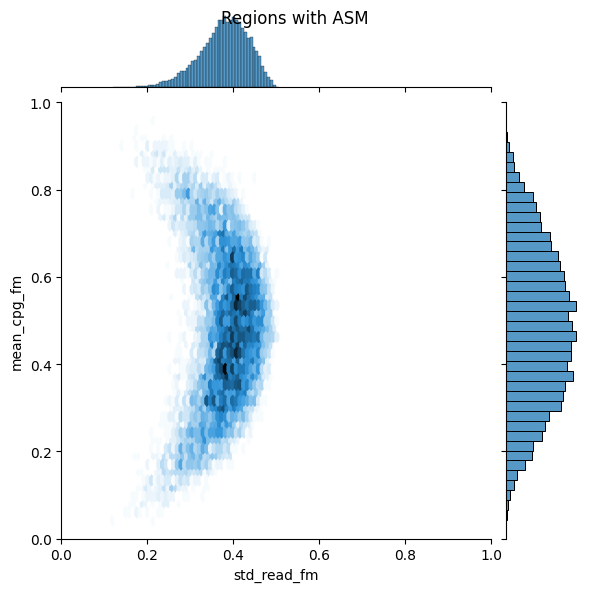

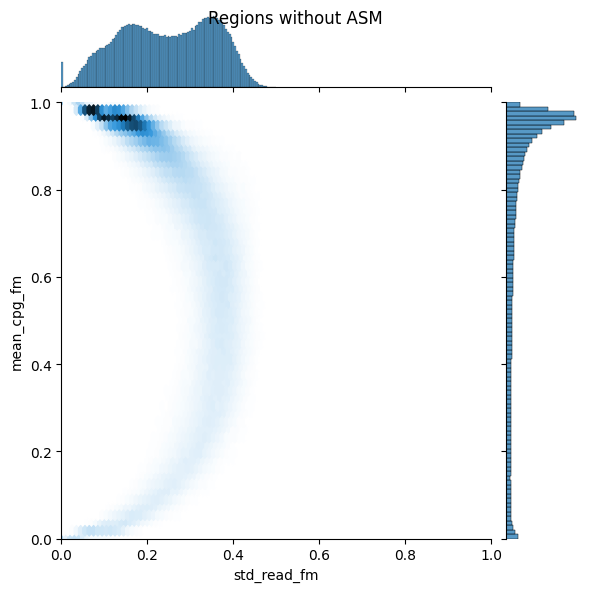

In [9]:
pos_df = df[df['asm'] ==1].copy(deep = True)
neg_df = df[df['asm'] ==0].copy(deep = True)

var_x = 'std_read_fm' # transition_from_4_to_4 std_read_fm
var_y = 'mean_cpg_fm' # mean_cpg_fm

sns.jointplot(x=var_x, y=var_y, data=pos_df,
              kind='hex', xlim=(0, 1), ylim=(0, 1))
plt.suptitle("Regions with ASM")

sns.jointplot(x=var_x, y=var_y, data=neg_df,
              kind='hex', xlim=(0, 1), ylim=(0, 1))
plt.suptitle("Regions without ASM")

# plt.savefig("with_ASM.png", dpi = 600)
# files.download("with_ASM.png")


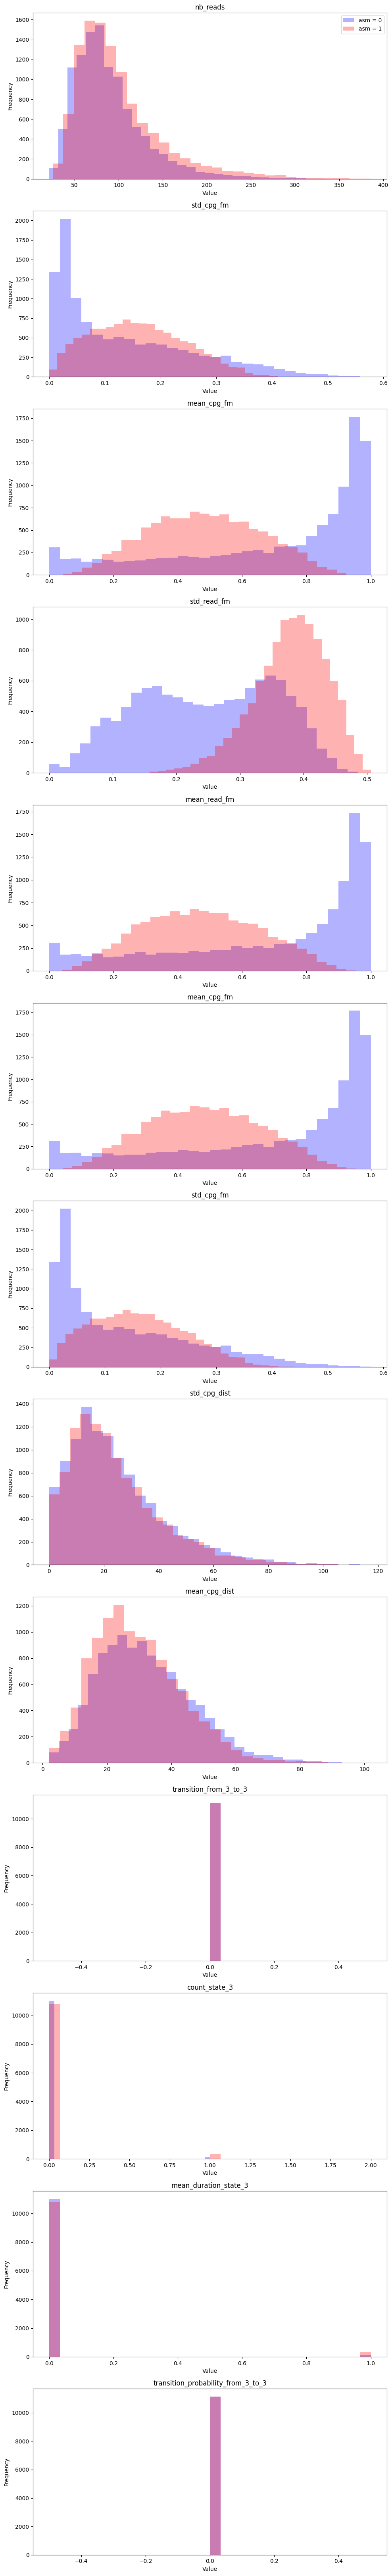

In [10]:
plot_balanced_overlayed_distributions(df,
                                       ['nb_reads',
                                       'std_cpg_fm',
                                       'mean_cpg_fm',
                                       'std_read_fm',
                                       'mean_read_fm',
                                        'mean_cpg_fm',
                                        'std_cpg_fm',
                                       'std_cpg_dist',
                                       'mean_cpg_dist',
                                        'transition_from_3_to_3',
                                        'count_state_3',
                                        'mean_duration_state_3',
                                        'transition_probability_from_3_to_3'

                                       ])

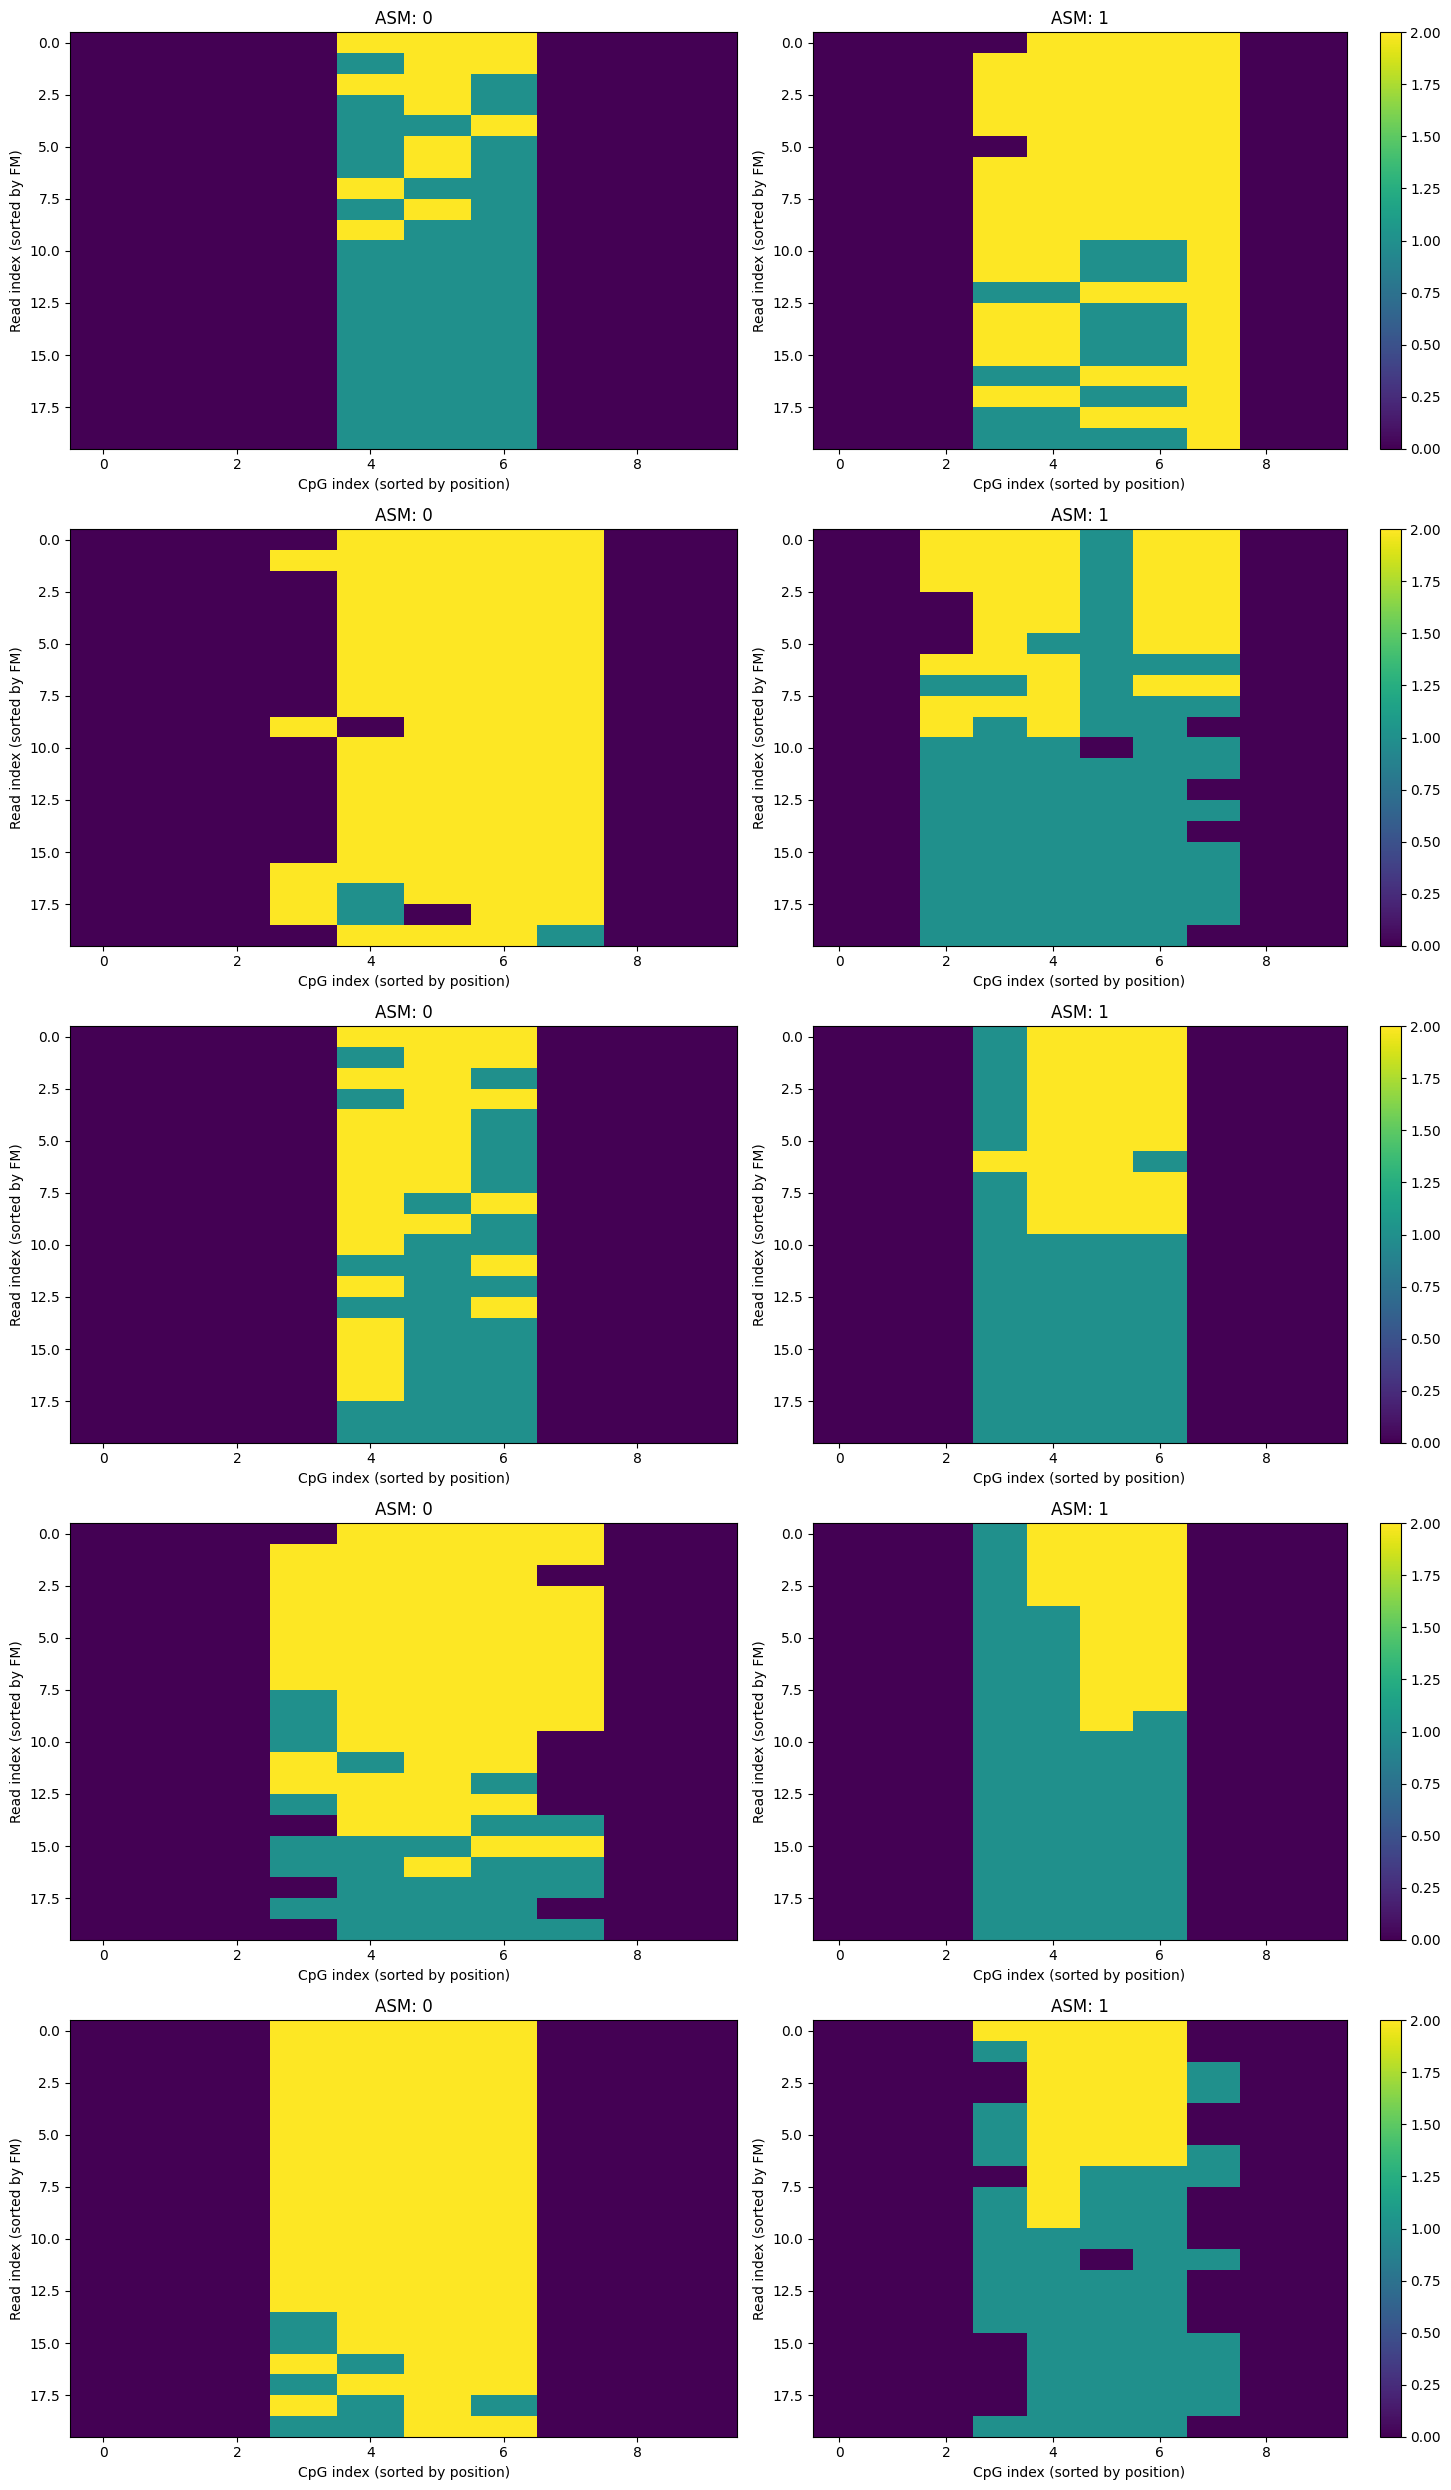

In [11]:
plot_cpg_regions_from_df(df, 'cpgs_w_padding', 'asm', 5)


## Number of CpGs used in training the HMM

In [12]:
query = f"SELECT cpg_directional_fm FROM {PROJECT_ID}.{ML_DATASET}.TRAINING WHERE  cpg_directional_fm IS NOT NULL"
hmm_df = bq_client.query(query).to_dataframe()

# Convert list of strings
hmm_df['cpg_directional_fm'] = hmm_df['cpg_directional_fm'].apply(lambda x: ast.literal_eval(x.strip('"')))

In [13]:
training_seq = np.concatenate(
        hmm_df['cpg_directional_fm'].tolist()
    )

print(f"Number of CpGs used in training the HMM: {len(training_seq)}")

Number of CpGs used in training the HMM: 22006592


In [14]:
minimum = np.min(training_seq)
maximum = np.max(training_seq)
percentile_25 = np.percentile(training_seq, 25)  # 25th percentile
percentile_50 = np.percentile(training_seq, 50)  # Median or 50th percentile
percentile_75 = np.percentile(training_seq, 75)  # 75th percentile

print(f"Minimum: {minimum}, Maximum: {maximum}, median: {percentile_50}")

print(f"Set of unique values: {np.unique(training_seq)}")

Minimum: -1.0, Maximum: 1.0, median: 0.2
Set of unique values: [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


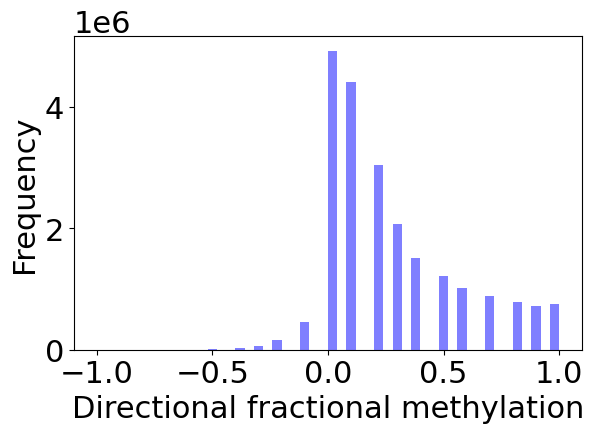

In [15]:
plt.rcParams.update({'font.size': 22})  # Adjust the number to suit your needs
plt.hist(training_seq, bins=50, alpha=0.5, color='blue', rwidth = 10)  # You can adjust the number of bins and color
#plt.title('Histogram of CpG directional fractional methylation')
plt.xlabel('Directional fractional methylation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('CpG_dir_frac_methyl.png', format='png', dpi=600)  # Increase dpi for higher resolution
plt.show()


In [16]:
from collections import Counter
# Count the frequency of each value in 'cpg_directional_fm' column
frequency = Counter(training_seq)
display(frequency)


Counter({0.0: 4914204,
         0.1: 4408874,
         0.2: 3035414,
         0.4: 1511423,
         0.3: 2062221,
         -0.1: 450555,
         0.5: 1206648,
         0.8: 788709,
         0.9: 711547,
         0.6: 1020793,
         0.7: 890913,
         1.0: 753637,
         -0.2: 158989,
         -0.4: 21844,
         -0.3: 61699,
         -0.5: 6781,
         -0.6: 1809,
         -0.7: 435,
         -0.8: 74,
         -0.9: 22,
         -1.0: 1})

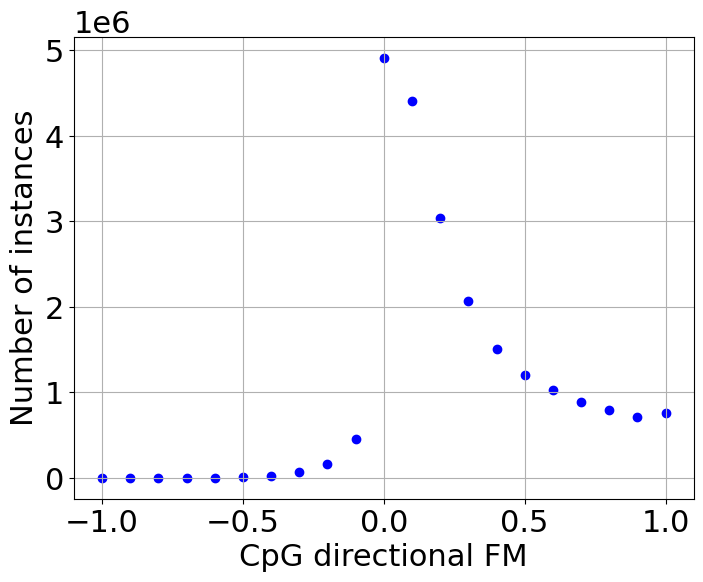

In [17]:
keys = list(frequency.keys())
values = list(frequency.values())

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(keys, values, color='blue')
plt.xlabel('CpG directional FM')
plt.ylabel('Number of instances')
#plt.title('Distribution of Counter Object')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


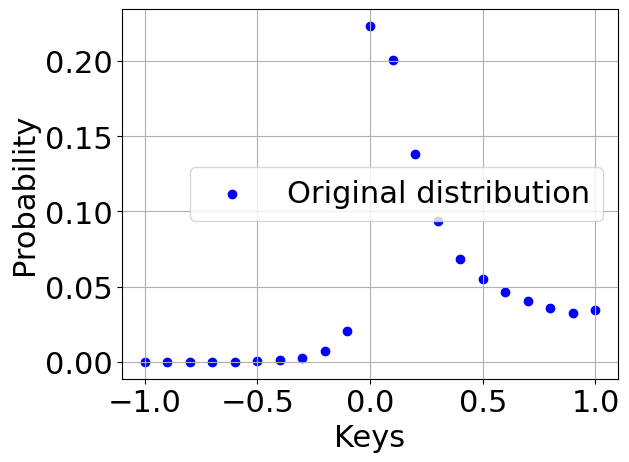

In [18]:
from scipy.stats import norm
from scipy.stats import beta
total_counts = sum(frequency.values())
probabilities = {key: value / total_counts for key, value in frequency.items()}
keys = np.array(list(probabilities.keys()))
prob_values = np.array(list(probabilities.values()))

alpha, beta_fit, loc, scale = beta.fit(prob_values)
mean = np.sum(keys * prob_values)
variance = np.sum((keys - mean)**2 * prob_values)
std_dev = np.sqrt(variance)

# Convert keys to an ordered list and sort them
#keys = sorted(list(probabilities.keys()))

# Plot the histogram of probabilities
#plt.bar(keys, [probabilities[key] for key in keys], color='blue', alpha=0.1, label='Normalized Frequencies')


# Plot the fitted beta distribution
x = np.linspace(-1, 1, 100)
plt.scatter(keys, prob_values, color = 'blue', label='Original distribution')
#pdf_fitted = beta.pdf(x, alpha, beta_fit, loc, scale)
pdf_fitted = norm.pdf(x, loc=mean, scale=std_dev)
#plt.plot(x, pdf_fitted, 'r-', label='Fitted Gaussian distribution')

#plt.plot(x, pdf_fitted, 'r-', label='Fitted Beta distribution')

plt.xlabel('Keys')
plt.ylabel('Probability')
#plt.title('Beta Distribution Fitted to Counter Distribution')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


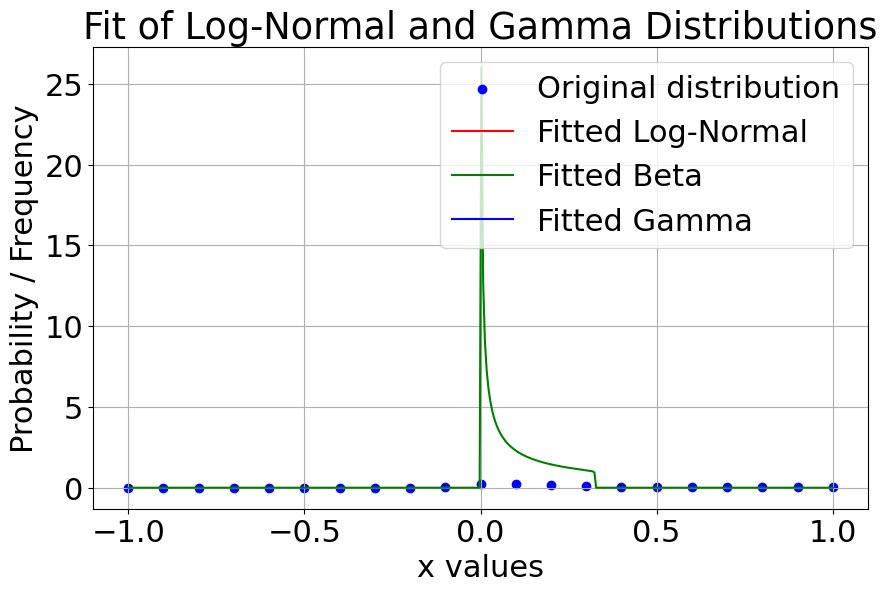

In [19]:
from scipy.stats import lognorm, gamma, beta
from scipy.optimize import curve_fit



# Example data
# x = np.array([...])  # your x-values
# y = np.array([...])  # your y-values, treated as frequencies

probabilities = {key: value / total_counts for key, value in frequency.items()}
keys = np.array(list(probabilities.keys()))
prob_values = np.array(list(probabilities.values()))


# To fit the distributions, we need to define a probability density function for each
def log_normal_pdf(x, s, scale):
    return lognorm.pdf(x, s, scale=scale)

def gamma_pdf(x, a, scale):
    return gamma.pdf(x, a, scale=scale)

# Curve fitting using the defined PDFs
params_log_normal, _ = curve_fit(log_normal_pdf, keys, prob_values, p0=[1, np.mean(keys)])
params_gamma, _ = curve_fit(gamma_pdf, keys, prob_values, p0=[1, np.mean(keys)])
alpha, beta_fit, loc, scale = beta.fit(prob_values)

x_values = np.linspace(min(keys), max(keys), 400)
fitted_log_normal = log_normal_pdf(x_values, *params_log_normal)
fitted_gamma = gamma_pdf(x_values, *params_gamma)
beta_fitted = beta.pdf(x_values, alpha, beta_fit, loc, scale)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(keys, prob_values, color='blue', label='Original distribution')
plt.plot(x_values, fitted_log_normal, 'r-', label='Fitted Log-Normal')
plt.plot(x_values, beta_fitted, 'g-', label='Fitted Beta')
plt.plot(x_values, fitted_gamma, 'b-', label='Fitted Gamma')

plt.title('Fit of Log-Normal and Gamma Distributions')
plt.xlabel('x values')
plt.ylabel('Probability / Frequency')
plt.legend()
plt.grid(True)
plt.show()

## HMM model structure

In [21]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # Initialize a client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # Get the blob
    blob = bucket.blob(source_blob_name)

    # Download the blob to a local file
    blob.download_to_filename(destination_file_name)
    print(f"Blob {source_blob_name} downloaded to {destination_file_name}.")

# Example usage:
model_path = 'samples_250bp/models/hmm_model_4fa1c65_19states.joblib'
model_file_name = '/hmh_model.joblib'

download_blob(BUCKET, model_path, model_file_name)

Blob samples_250bp/models/hmm_model_4fa1c65_19states.joblib downloaded to /hmh_model.joblib.


In [22]:
# Load model
import joblib
model = joblib.load('/hmh_model.joblib')


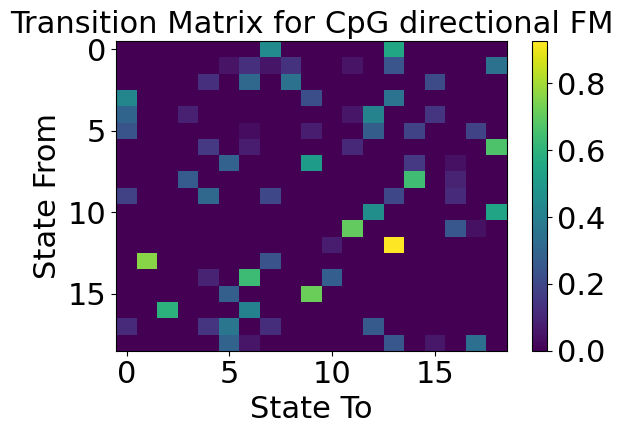

In [23]:
plt.rcParams.update({'font.size': 22})  # Adjust the number to suit your needs

# Assuming best_model.transmat_ is defined and contains the transition matrix you want to plot
# Create the figure and axis
fig, ax = plt.subplots()

# Plot the transition matrix
cax = ax.imshow(model.transmat_, aspect='auto')

# Create a colorbar with a reference to the imshow plot
fig.colorbar(cax)

# Set the title and labels
ax.set_title('Transition Matrix for CpG directional FM', fontsize = 22)
ax.set_xlabel('State To')
ax.set_ylabel('State From')
plt.tight_layout()
plt.savefig('transition_matrix.png', format='png', dpi=600)  # Increase dpi for higher resolution
# Display the plot
plt.show()

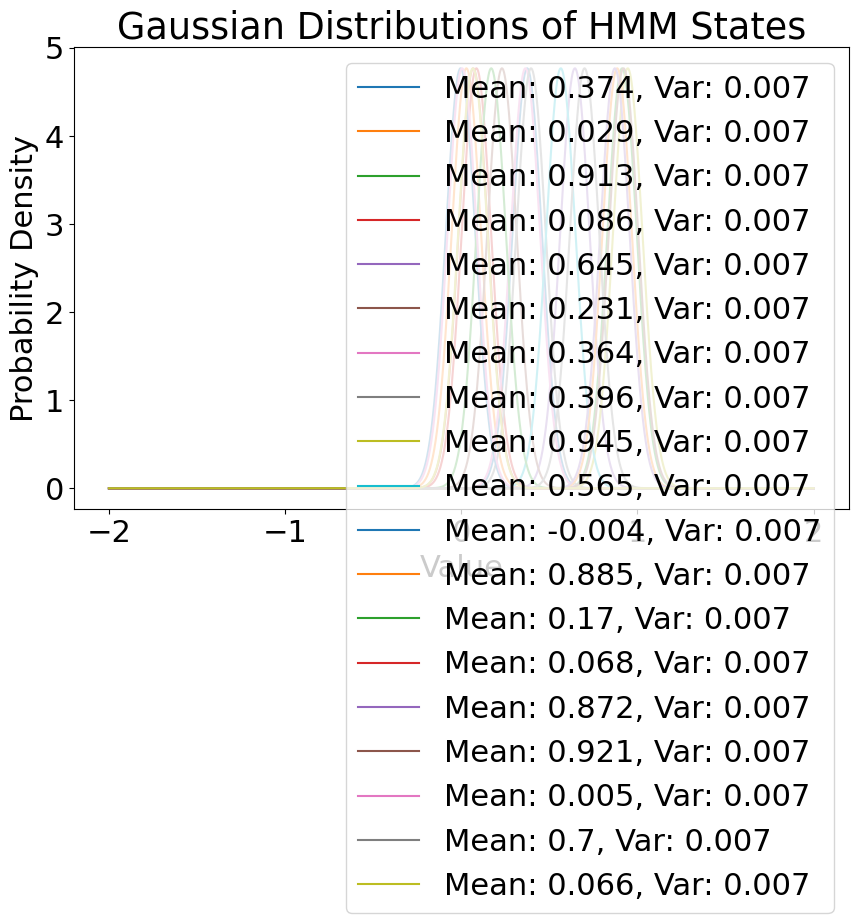

In [24]:
from scipy.stats import norm
# Example Gaussian parameters for 5 states
means = np.round(model.means_.flatten(),3)  # [1, 3, 5, 7, 9]
covariances = np.round(model.covars_.flatten(),3) #[0.5, 0.2, 1.0, 0.3, 0.7]  # Variance in this case

# Create a figure
plt.figure(figsize=(10, 6))

# Value range for x-axis
x = np.linspace(-2, 2, 1000)

# Plot each Gaussian
for mean, cov in zip(means, covariances):
    plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), label=f'Mean: {mean}, Var: {cov}')

plt.title('Gaussian Distributions of HMM States')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

plt.show()

In [25]:
print("\nStart probabilities:")
print(model.startprob_)

print("\nTransition matrix:")
print(model.transmat_)

print("\nGaussian distribution covariances:")
print(model.covars_)

print("\nGaussian means:")
print(model.means_)


Start probabilities:
[3.99311697e-232 3.49984498e-065 0.00000000e+000 4.26607321e-058
 0.00000000e+000 3.51016759e-207 3.14072654e-288 0.00000000e+000
 0.00000000e+000 0.00000000e+000 9.11356524e-060 0.00000000e+000
 1.00000000e+000 1.68020274e-024 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 7.92716786e-057]

Transition matrix:
[[2.62568658e-028 1.36840190e-029 7.97302829e-116 1.03146733e-031
  1.91374838e-026 1.12592819e-025 8.80458594e-040 4.47555126e-001
  2.31216643e-146 7.83631914e-018 2.32323114e-028 2.22042091e-164
  2.88446921e-018 5.52444874e-001 1.22704903e-082 1.30317159e-124
  1.56162482e-070 1.08987607e-031 1.63268571e-016]
 [2.63981976e-067 4.98942437e-012 2.10623163e-080 1.01867221e-004
  3.65944679e-128 4.87778116e-002 1.25331301e-001 5.32454270e-002
  1.34803977e-001 3.17515681e-054 3.96268128e-016 4.84088070e-002
  8.14241164e-018 2.43102932e-001 5.58654259e-094 5.99308422e-117
  1.62202100e-047 2.17763497e-092 3.46227877e-001]
 [7.31552037e-026 